In [1]:
import requests
import numpy as np
import pandas as pd
import time

from bs4 import BeautifulSoup
from fake_useragent import UserAgent

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Парсинг
Будем парсит отзывы критиков о фильмах с сайта https://www.rottentomatoes.com/ и их сентимент метки

In [2]:
rottentomatoes_link = 'https://www.rottentomatoes.com/'
movies_types_links = ['browse/movies_at_home/', 'browse/movies_in_theaters/']
count_pages = 30

def page_link(page_num):
    return f'?page={page_num}'

def sleep():
    time.sleep(np.random.uniform(3, 7))

### Функция для парсинга ссылок фильмов на текущей странице

In [3]:
def get_film_links_from_current_page(page_link):
    response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
    sleep()
    if not response.ok:
        return []
    bs = BeautifulSoup(response.content, 'html.parser')
    film_links = bs.find_all('a', attrs = {'class':'js-tile-link'})
    first_type_links = [link.attrs['href'] for link in film_links]
    film_links = bs.find_all('a', attrs = {'data-track':'scores'})
    second_type_links = [link.attrs['href'] for link in film_links]
    return first_type_links + second_type_links

get_film_links_from_current_page('https://www.rottentomatoes.com/browse/movies_at_home?page=1')

['/m/this_closeness',
 '/m/the_real_bros_of_simi_valley_the_movie',
 '/m/goyo',
 '/m/i_am_celine_dion',
 '/m/hummingbirds',
 '/m/tell_that_to_the_winter_sea',
 '/m/boneyard_2024',
 '/m/chestnut',
 '/m/geoff_mcfetridge_drawing_a_life',
 '/m/cold_blows_the_wind',
 '/m/beverly_hills_cop_axel_f',
 '/m/space_cadet',
 '/m/the_imaginary',
 '/m/murder_company',
 '/m/freydis_and_gudrid',
 '/m/a_family_affair_2024_2',
 '/m/furiosa_a_mad_max_saga',
 '/m/hit_man_2023',
 '/m/trigger_warning_2024',
 '/m/the_fall_guy_2024',
 '/m/if_2024',
 '/m/inside_out_2015',
 '/m/the_watchers_2024',
 '/m/a_quiet_place_2018',
 '/m/civil_war_2024',
 '/m/i_saw_the_tv_glow',
 '/m/a_quiet_place_part_ii',
 '/m/the_last_stop_in_yuma_county']

### Функции для парсинга фитч и целевой перменной фильма

In [4]:
def get_move_name(bs):
    return bs.find('a', attrs={'class', 'sidebar-title'}).text.strip()

def get_sentiment(bs):
    score_row = bs.find('score-icon-critics')
    return score_row['sentiment']

def get_review(bs):
    review_row = bs.find('p', attrs={'class', 'review-text'})
    return review_row.text.strip()

def get_critics_reviews_and_labels(movie_link):
    response = requests.get(rottentomatoes_link + movie_link + '/reviews' , headers={'User-Agent': UserAgent().chrome})
    sleep()
    if not response.ok:
        return []
    bs = BeautifulSoup(response.content, 'html.parser')
    movie_name = get_move_name(bs)
    review_rows = bs.find_all('div', attrs={'class':'review-row'})
    return [{'Movie': movie_name, 'Review': get_review(row), 'Sentiment': get_sentiment(row)} for row in review_rows] 

get_critics_reviews_and_labels('/m/i_am_celine_dion')

[{'Movie': 'I Am: Celine Dion',
  'Review': 'Even if she can’t sing the way she used to, Dion has given us a brave and shatteringly powerful documentary.',
  'Sentiment': 'POSITIVE'},
 {'Movie': 'I Am: Celine Dion',
  'Review': 'A deeply uncomfortable film that is unafraid to address themes of grief and regret, director Irene Taylor’s I Am: Celine Dion is more a celebration of the pop star’s spirit than her many professional achievements.',
  'Sentiment': 'POSITIVE'},
 {'Movie': 'I Am: Celine Dion',
  'Review': 'Even if you are completely disinterested in Dion, if you are a human being who has not found a way to achieve immortality, “I Am: Celine Dion” is still for you.',
  'Sentiment': 'POSITIVE'},
 {'Movie': 'I Am: Celine Dion',
  'Review': 'Emotionally stripped bare, Dion introduces a rarely seen side of herself outside of the spotlight in filmmaker Irene Taylor’s intimate portrait, I Am: Celine Dion, which will appeal to viewers whether you are a fan of her or not.',
  'Sentiment':

### Парсим

In [5]:
from tqdm import tqdm_notebook

df = pd.DataFrame(columns=['Movie', 'Review', 'Sentiment'])

for type_film_link in tqdm_notebook(movies_types_links, desc='Movie types'):
    link = rottentomatoes_link + type_film_link + page_link(count_pages)
    film_links = get_film_links_from_current_page(link)
    for film_link in tqdm_notebook(film_links, desc='Films'):
        data = get_critics_reviews_and_labels(film_link)
        df = df._append(data, ignore_index=True)
    sleep()

df.to_csv('rottentomatoes_sentiment.csv', index=False)

Movie types:   0%|          | 0/2 [00:00<?, ?it/s]

Films:   0%|          | 0/140 [00:00<?, ?it/s]

Films:   0%|          | 0/88 [00:00<?, ?it/s]

# NLP часть

In [6]:
df = pd.read_csv('rottentomatoes_sentiment.csv')
df = df.dropna()
df

,Movie,Review,Sentiment
0,This Closeness,Many of life’s important moments don’t result ...,POSITIVE
1,This Closeness,Zauhar gets to the heart of her characters’ de...,POSITIVE
2,This Closeness,There's a lot to like in this journey of two h...,POSITIVE
3,This Closeness,"At first, Zauhar’s project for the film isn’t ...",POSITIVE
4,This Closeness,I think I’m too old to fully “get” This Closen...,POSITIVE
...,...,...,...
3655,Majority Rules,Politically-minded viewers will love this deep...,POSITIVE
3656,Majority Rules,The film offers up at least one unquestionably...,POSITIVE
3657,How to Come Alive with Norman Mailer,Zimbalist hits on a great idea: arrange the fi...,POSITIVE
3658,How to Come Alive with Norman Mailer,"A captivating, illuminating, warts-and-all doc...",POSITIVE


In [7]:
def sentiment2labelnum(sentiment):
    if sentiment == 'POSITIVE':
        return 1 
    return 0

df['Sentiment'] = df['Sentiment'].apply(sentiment2labelnum)

In [8]:
import nltk

# Загружаем стоп слова
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# пример стоп слов
print(len(stop_words))
print(stop_words[:10])

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to /home/nikita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
import re
from tqdm import tqdm

regex = re.compile(r'[A-z]+')
word_tokenizer = nltk.WordPunctTokenizer()

def words_only(text, regex=regex):
    try:
        return ' '.join(regex.findall(text)).lower()
    except:
        return ''
    
def process_data(data):
    texts = []
    for row in tqdm(data.itertuples()):
        text        = row.Review.replace(row.Movie, '')
        text_lower  = words_only(text)
        tokens      = word_tokenizer.tokenize(text_lower)

        tokens = [word for word in tokens if (word not in stop_words and not word.isnumeric())]

        texts.append(tokens)

    return texts

In [10]:
y = df['Sentiment']
texts = process_data(df)
# example
i = 1
print("Label: ", y[i])
print("Tokens: ", texts[i][:10])

3629it [00:00, 18005.82it/s]

Label:  1
Tokens:  ['zauhar', 'gets', 'heart', 'characters', 'deepest', 'fears', 'desires', 'way', 'disarmingly', 'funny']


Нормализация слов

In [11]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

# применяем лемматизацию ко всем текстам
for i in tqdm(range(len(texts))):           # tqdm_notebook создает шкалу прогресса :)
   text_stemmed = ' '.join([stemmer.stem(x) for x in texts[i]]) # применяем лемматизацию для каждого слова в тексте
   texts[i] = text_stemmed             # объединяем все слова в одну строку через пробел

100%|██████████| 3629/3629 [00:00<00:00, 6583.99it/s]


In [12]:
from sklearn.model_selection import train_test_split

text_train, text_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df= 0.8, max_features=1200, norm=None)
X_train = vectorizer.fit_transform(text_train)
X_test = vectorizer.transform(text_test)

# Топ-10 слов
vectorizer.get_feature_names_out()[:10]

array(['abil', 'abl', 'absolut', 'absurd', 'accept', 'account', 'achiev',
       'across', 'act', 'action'], dtype=object)

### Логистическая регрессия

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.2, max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

pred_test = lr.predict(X_test)

Оценка качества

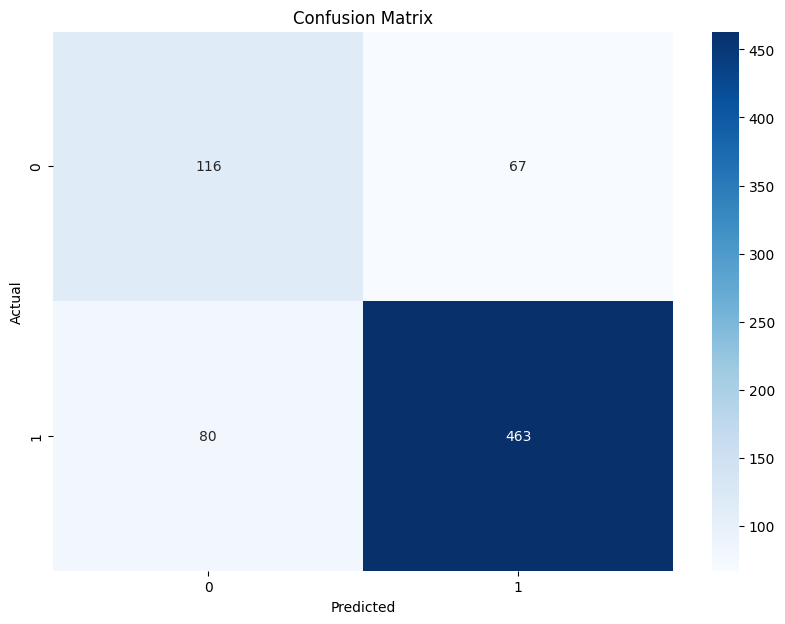

              precision    recall  f1-score   support

           0       0.59      0.63      0.61       183
           1       0.87      0.85      0.86       543

    accuracy                           0.80       726
   macro avg       0.73      0.74      0.74       726
weighted avg       0.80      0.80      0.80       726



In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

# Вычисление матрицы ошибок
conf_matrix = confusion_matrix(y_test, pred_test)

# Отображение матрицы ошибок
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true=y_test, y_pred=pred_test))

Визуализация получившихся коэффициентов регрессии

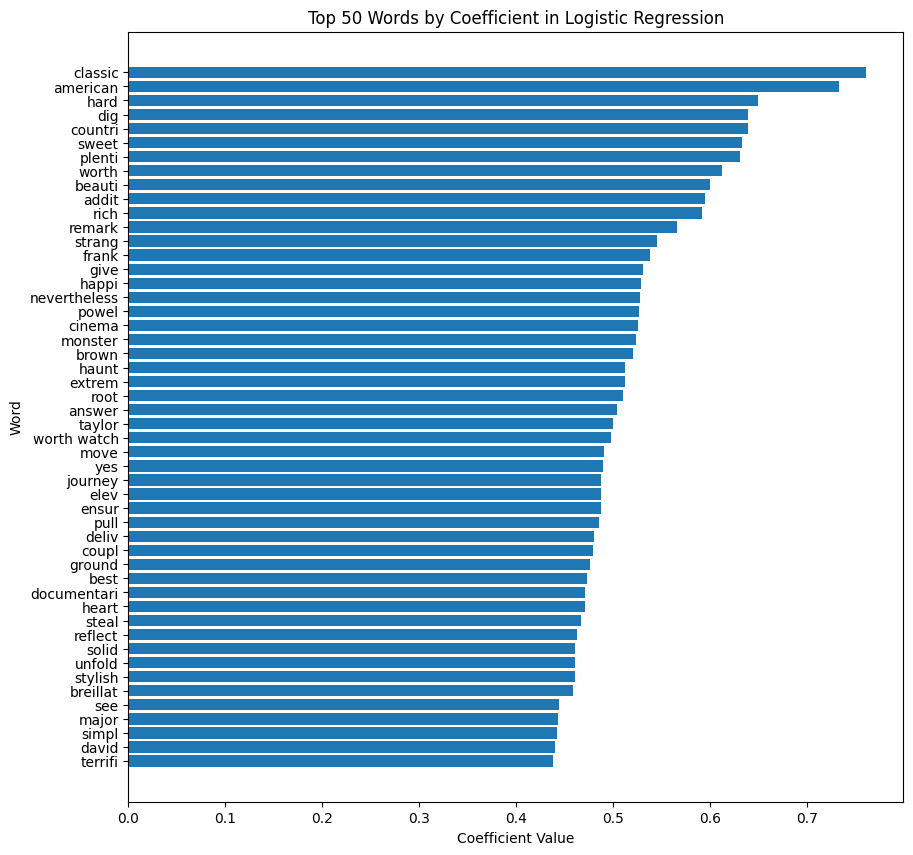

In [16]:
# Визуализация коэффициентов регрессии
feature_names = vectorizer.get_feature_names_out()
coefficients = lr.coef_[0]

# Получение топ-50 слов
top_words_idx = np.argsort(coefficients)[-50:]
top_words = [feature_names[idx] for idx in top_words_idx]

plt.figure(figsize=(10, 10))
plt.barh(top_words, coefficients[top_words_idx])
plt.xlabel('Coefficient Value')
plt.ylabel('Word')
plt.title('Top 50 Words by Coefficient in Logistic Regression')
plt.show()

Как можно заметить, если фильм снят в классическом стиле кинематографа и в США, то скорее всего он обречен на положительный отзыв у критиков